##  Resize DINOv2 Positional Embeddings for Larger Input Resolution

In [ ]:
from transformers import AutoImageProcessor, AutoModel
import torch
import math

# Load the pretrained DINOv2-small visual encoder
visual_encoder = AutoModel.from_pretrained('facebook/dinov2-small')

# Define the new image size we want to adapt the model to
new_img_size = 896

# Extract the patch size used by the model (typically 14 for DINOv2-small)
patch_size = visual_encoder.config.patch_size

# Compute how many patches the new image will be divided into (excluding the CLS token)
new_num_patches = (new_img_size // patch_size) ** 2
new_grid_size = new_img_size // patch_size  # the new grid is square

# Get the original positional embeddings from the model
pos_embed = visual_encoder.embeddings.position_embeddings  # shape: (1, 257, dim)
cls_pos_embed = pos_embed[:, 0:1, :]               # CLS token's positional embedding (1 token)
patch_pos_embed = pos_embed[:, 1:, :]              # Patch tokens' positional embeddings (256 tokens)
dim = patch_pos_embed.shape[-1]                    # Embedding dimension

# Reshape patch positional embeddings to 2D spatial grid for interpolation
patch_pos_embed = patch_pos_embed.reshape(
    1, int(math.sqrt(patch_pos_embed.shape[1])), int(math.sqrt(patch_pos_embed.shape[1])), dim
)
patch_pos_embed = patch_pos_embed.permute(0, 3, 1, 2)  # Change shape to (1, dim, H, W)

# Interpolate positional embeddings to match the new grid size (bicubic interpolation)
patch_pos_embed = torch.nn.functional.interpolate(
    patch_pos_embed,
    size=(new_grid_size, new_grid_size),
    mode='bicubic',
    align_corners=False
)

# Flatten interpolated grid back to sequence form: (1, new_num_patches, dim)
patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).reshape(1, new_num_patches, dim)

# Concatenate the CLS token embedding back to the beginning of the sequence
new_pos_embed = torch.cat((cls_pos_embed, patch_pos_embed), dim=1)

# Update the model with the new positional embeddings
visual_encoder.embeddings.position_embeddings = torch.nn.Parameter(new_pos_embed)


## Custom Dataset Loader for Typewritten Documents (Dahn Corpus) with PAGE XML Annotations

In [22]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset , DataLoader
from transformers import AutoImageProcessor
from torchvision import transforms
import numpy as np
class TypewrittenDataset(Dataset):
    def __init__(self, xml_folder, image_folder=None, transform=None):
        self.xml_folder = xml_folder
        self.image_folder = image_folder or xml_folder
        self.transform = transform

        self.samples = []
        self.ns = {'pg': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15'}

        for file in os.listdir(xml_folder):
            if not file.endswith(".xml"):
                continue

            xml_path = os.path.join(xml_folder, file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            page = root.find('pg:Page', self.ns)
            if page is None:
                continue

            image_filename = page.attrib.get('imageFilename')
            if not image_filename:
                continue

            image_path = os.path.join(self.image_folder, image_filename)
            if not os.path.exists(image_path):
                print(f"[Warning] Image not found: {image_path}")
                continue

            full_text = ""
            for text_region in page.findall('.//pg:TextRegion', self.ns):
                for text_line in text_region.findall('pg:TextLine', self.ns):
                    text_equiv = text_line.find('pg:TextEquiv', self.ns)
                    unicode_elem = text_equiv.find('pg:Unicode', self.ns) if text_equiv is not None else None
                    coords = text_line.find('pg:Coords', self.ns)
                    if unicode_elem is None or coords is None:
                        continue

                    bbox = coords.attrib['points'].strip()
                    text = unicode_elem.text.strip() if unicode_elem.text is not None else ""
                    points = [tuple(map(int, p.split(','))) for p in bbox.split()]
                    x_coords = [p[0] for p in points]
                    y_coords = [p[1] for p in points]


                    # full_text += f"<Txt>{text}<x_loc_min>{min(x_coords)}<y_loc_max>{max(y_coords)}<x_loc_max>{max(x_coords)}<y_loc_min>{min(y_coords)}"
                    full_text += f"{text} "
            full_text = full_text.strip()
            if full_text:
                self.samples.append((image_path, full_text))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, text = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        # image = torch.Tensor(np.array(self.transform(image)["pixel_values"]) ).squeeze()
        image = self.transform(image)
        return image, text
XML_FOLDER = 'dahncorpus/data/batch-01/page'  # Your PAGE XML file path
IMAGE_DIR = 'dahncorpus/data/batch-01/alto'

# processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
# Iterate through the data
processor = transforms.Compose([
    transforms.Resize((896, 896)),              # Direct resize to 224x224 without cropping
    transforms.ToTensor(),                      # Convert to tensor [0, 1]
    transforms.Normalize(                       # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
dataset = TypewrittenDataset(
    xml_folder=XML_FOLDER,
    image_folder=IMAGE_DIR,
    transform=processor
)

## CareCare Dataset Loader 

In [ ]:
from torch.utils.data import Dataset
import json
import os 
import base64
from io import BytesIO
from PIL import Image
import torchvision.transforms as transforms
class CareCareDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.samples = []
        self.special_tokens = set()
        for folder in os.listdir(data_folder):
            folder_path = os.path.join(data_folder, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('.json'):
                        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
                            data = json.load(f)
                        
                        entity_annotations = self._extract_entities(data)
                        image_string = data.get("pages", [])[0].get("image", {"content":""}).get("content","")
                        full_text="<Txt>"
                        for entity_type, mention_text in entity_annotations:
                            special_token = f"<{entity_type.lower().replace('_', '-')}>"
                            self.special_tokens.add(special_token)
                            full_text += f" {special_token} {mention_text.strip()}"
                        self.samples.append((image_string, full_text.strip()))
    
    
    def _extract_entities(self,data):
        entities = data.get("entities", [])
        entity_annotations = []

        for entity in entities:
            mention_text = entity.get("mentionText", "").strip()
            entity_type = entity.get("type", "").strip()
            if mention_text and entity_type:
                entity_annotations.append((entity_type, mention_text))

        return entity_annotations
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_string, text = self.samples[idx]
        # Decode base64 string to image
        image_bytes = base64.b64decode(image_string)
        image = Image.open(BytesIO(image_bytes)).convert("RGB")
        # image = torch.Tensor(np.array(self.transform(image)["pixel_values"]) ).squeeze()
        image = self.transform(image)
        return image, text


# processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
# Iterate through the data
processor = transforms.Compose([
    transforms.Resize((896, 896)),             
    transforms.ToTensor(),                      # Convert to tensor [0, 1]
    transforms.Normalize(                       # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
dataset = CareCareDataset(data_folder='dataset/train', transform=processor)

## Vision-to-Language Feature Projection Module

In [ ]:
import torch.nn as nn

# Define a lightweight projection module to map visual encoder outputs to language model embedding space
class VisionToLanguageBridge(nn.Module):
    def __init__(self, vision_dim=384, lang_dim=512):  # vision_dim: output dim of visual encoder; lang_dim: hidden size of language model
        super().__init__()

        # Use a small MLP to project visual features into the language model space
        self.proj = nn.Sequential(
            nn.Linear(vision_dim, 4 * lang_dim),  # Expand to a higher-dimensional space
            nn.GELU(),                            # Apply GELU activation
            nn.Linear(4 * lang_dim, lang_dim)     # Project back down to lang_dim
        )

    def forward(self, x):
        # Input: visual token embeddings from the vision encoder
        # Output: transformed embeddings compatible with the language model
        return self.proj(x)


## Load and Partially Fine-Tune a French Causal Language Model (Pagnol)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load the tokenizer and causal language model (Pagnol-small by LightOn)
model_name = "lightonai/pagnol-small"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
language_model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

# Print vocabulary size for reference
print(len(tokenizer))

# Freeze all model parameters to prevent updates during training
for param in language_model.parameters():
    param.requires_grad = False

# Unfreeze only the input token embeddings to allow learning new word representations
for param in language_model.get_input_embeddings().parameters():
    param.requires_grad = True

# Unfreeze the last transformer block to adapt high-level language features
for param in language_model.transformer.h[-1].parameters():
    param.requires_grad = True

# Optionally unfreeze the final output projection layer (lm_head)
for param in language_model.lm_head.parameters():
    param.requires_grad = True

# --- OPTIONAL: Add custom special tokens and resize model vocabulary ---
# special_tokens_dict = {
#     "additional_special_tokens": ["<Txt>", "<eos>", "<x_loc_min>", "<y_loc_max>", "<x_loc_max>", "<y_loc_min>"]
# }
# num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)
# vocab_size = len(tokenizer)

# language_model.resize_token_embeddings(vocab_size)

# # Replace the lm_head to match new vocab size if necessary
# language_model.lm_head = torch.nn.Linear(language_model.config.n_embd, vocab_size, bias=False).to(language_model.device)

# --- OPTIONAL: Generate text from a prompt using the model ---
# generator = pipeline(
#     'text-generation',
#     model=language_model,
#     tokenizer=tokenizer
# )
# prompt = "<user> Salut PAGnol, comment ça va ? <bot> c'est"
# output = generator(prompt, max_length=500, do_sample=True, temperature=0.7)
# print(output[0]['generated_text'])


50262


##  End-to-End Vision-Language Model with Visual Prompting for Text Generation

In [ ]:
import torch
import torch.nn as nn

# Define a multimodal model that injects visual information as a prefix to the language model
class VisionLanguageModel(nn.Module):
    def __init__(self, vision_model, bridge, language_model, tokenizer):
        super().__init__()
        self.vision_model = vision_model              # Pretrained vision encoder (e.g., DINOv2)
        self.bridge = bridge                          # MLP to map visual embedding → LM hidden size
        self.language_model = language_model          # Causal language model (e.g., Pagnol)
        self.tokenizer = tokenizer                    # Associated tokenizer for special token IDs

    def forward(self, image_tensor, input_ids, attention_mask):
        # Extract patch-level features from the vision model and isolate the CLS token
        features = self.vision_model(pixel_values=image_tensor).last_hidden_state  # Shape: (B, 257, 384)
        cls_token = features[:, 0, :]  # Extract CLS token representing the full image (B, 384)

        # Project CLS token to the language model's embedding space
        vision_embed = self.bridge(cls_token)         # Shape: (B, hidden_size)

        # Prepare input embeddings by prepending vision embedding to the tokenized sequence
        vision_embed = vision_embed.unsqueeze(1)      # (B, 1, hidden_size)
        inputs_embeds = self.language_model.get_input_embeddings()(input_ids)  # (B, T, hidden_size)
        inputs_embeds = torch.cat([vision_embed, inputs_embeds], dim=1)        # (B, T+1, hidden_size)

        # Update attention mask to account for added vision token
        vision_attention = torch.ones(attention_mask.size(0), 1, device=attention_mask.device)
        attention_mask = torch.cat([vision_attention, attention_mask], dim=1)   # (B, T+1)

        # Prepare labels: ignore vision token and predict input continuation + EOS
        eos = torch.full((input_ids.size(0), 1), self.tokenizer.eos_token_id, device=input_ids.device)
        ignore_token = torch.full((input_ids.size(0), 1), -100, device=input_ids.device)
        labels = torch.cat([ignore_token, input_ids[:, 1:], eos], dim=1)        # Shifted targets

        # Forward pass through the language model
        outputs = self.language_model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels
        )

        return outputs  # Loss and logits

    def generate(self, image_tensor, max_length=64, num_beams=3):
        with torch.no_grad():
            # Extract and bridge CLS token as vision embedding
            features = self.vision_model(pixel_values=image_tensor).last_hidden_state
            cls_token = features[:, 0, :]
            vision_embed = self.bridge(cls_token).unsqueeze(1)  # (B, 1, hidden_size)

            # Generate text using the vision embedding as prompt
            outputs = self.language_model.generate(
                inputs_embeds=vision_embed,
                max_length=max_length,
                num_beams=num_beams,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
                bos_token_id=self.tokenizer.bos_token_id,
                do_sample=True,             # Enable sampling for diversity
                top_p=0.9,                  # Nucleus sampling
                temperature=1.0             # Sampling temperature
            )
            return outputs  # Token IDs of generated text


In [30]:
def collate_fn(batch):
    images, texts = zip(*batch)
    images = torch.stack(images)
    
    encodings = tokenizer(
        list(texts),
        max_length=1023,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    return images, encodings['input_ids'], encodings['attention_mask']


## Train and Evaluate a Vision-Language Model with Cosine Learning Rate Scheduling

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

# Set device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Split dataset into training (85%) and evaluation (15%) subsets
train_size = int(0.85 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Create data loaders with custom collate function for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Initialize the model and optimizer
bridge = VisionToLanguageBridge(vision_dim=384, lang_dim=language_model.config.hidden_size)
vlm = VisionLanguageModel(
    vision_model=visual_encoder,
    bridge=bridge,
    language_model=language_model,
    tokenizer=tokenizer
).to(device)

# Optional: Load pretrained weights if continuing training
# vlm.load_state_dict(torch.load("vlm_weights_base.pth", map_location=device))

# Define optimizer and cosine learning rate scheduler
optimizer = optim.AdamW(vlm.parameters(), lr=5e-4, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

# Training configuration
num_epochs = 20
log_interval = 21
train_losses = []
eval_losses = []

# Training + Evaluation loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # ----------- Evaluation phase -----------
    vlm.eval()
    total_eval_loss = 0
    with torch.no_grad():
        for images, input_ids, attention_mask in eval_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = vlm(images, input_ids, attention_mask)
            total_eval_loss += outputs.loss.item()

        avg_eval_loss = total_eval_loss / len(eval_loader)
        eval_losses.append(avg_eval_loss)
        print(f"Epoch {epoch + 1} - Eval Loss: {avg_eval_loss:.4f}")

        # Show one prediction for qualitative inspection
        outputs = vlm.generate(images[0].unsqueeze(0), max_length=128)
        for output in outputs:
            pred_text = tokenizer.decode(output)
            gt_text = tokenizer.decode(input_ids[0])[:150]
            print("Prediction:", pred_text)
            print("Ground Truth:", gt_text)

    # ----------- Training phase -----------
    vlm.train()
    running_train_loss = 0
    batch_count = 0

    for i, (images, input_ids, attention_mask) in enumerate(tqdm(train_loader), 1):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = vlm(images, input_ids, attention_mask)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zer


cuda

Epoch 1/20
Epoch 1 - Eval Loss: 11.6889
Prediction: ., Station Station Station L Station Station Station Station Station Station Radio<EOS>
geound: - 4 - de dégoût et même d’inquiétude le monde entier ; cette igno- minieuse brutalité du caporalisme prussien devenue souveraine maîtresse, par la for


 14%|█▎        | 3/22 [00:09<00:57,  3.05s/it]

In [8]:
for name, param in vlm.named_parameters():
    if param.requires_grad:
        print(name)

vision_model.embeddings.cls_token
vision_model.embeddings.mask_token
vision_model.embeddings.position_embeddings
vision_model.embeddings.patch_embeddings.projection.weight
vision_model.embeddings.patch_embeddings.projection.bias
vision_model.encoder.layer.0.norm1.weight
vision_model.encoder.layer.0.norm1.bias
vision_model.encoder.layer.0.attention.attention.query.weight
vision_model.encoder.layer.0.attention.attention.query.bias
vision_model.encoder.layer.0.attention.attention.key.weight
vision_model.encoder.layer.0.attention.attention.key.bias
vision_model.encoder.layer.0.attention.attention.value.weight
vision_model.encoder.layer.0.attention.attention.value.bias
vision_model.encoder.layer.0.attention.output.dense.weight
vision_model.encoder.layer.0.attention.output.dense.bias
vision_model.encoder.layer.0.layer_scale1.lambda1
vision_model.encoder.layer.0.norm2.weight
vision_model.encoder.layer.0.norm2.bias
vision_model.encoder.layer.0.mlp.fc1.weight
vision_model.encoder.layer.0.mlp.fc

Model saved to vlm_weights.pth


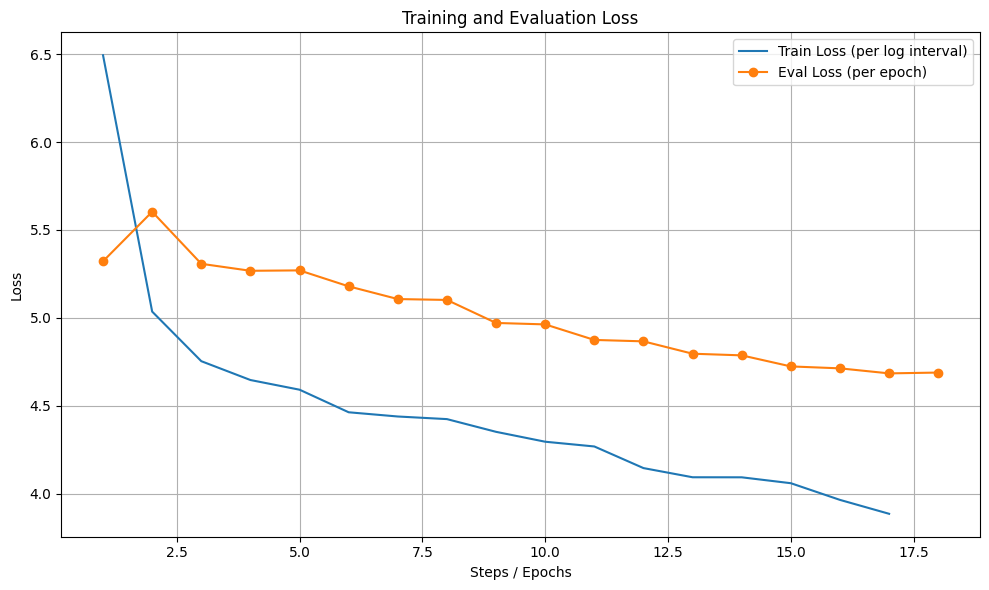

In [8]:
torch.save(vlm.state_dict(), "vlm_weights.pth")
print("Model saved to vlm_weights.pth")
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss (per log interval)')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Eval Loss (per epoch)', marker='o')
plt.xlabel('Steps / Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve_base.png")
plt.show()
